In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import datetime

def is_weekday(date_string):
    date_obj = datetime.datetime.strptime(date_string[:25], "Date: %Y-%m-%d %H:%M:%S")
    return date_obj.weekday() < 5

def get_travel_data(year,depart_hour_range=None,weight_column=None,weekday="All",origin_purp="All",dest_purp="All"):
    df = pd.read_csv("psrc_trips.csv")
    # df = df[(df["d_tract10"].astype(str).str[2:5]=="033")&(df["o_tract10"].astype(str).str[2:5]=="033")]
    df = df[df['depart_time_string'].str[6:10].notna() & df['depart_time_string'].str[17:19].notna()]
    df_2021 = df[(df['depart_time_string'].str[6:10] == str(year))]
    if depart_hour_range != None:
        df_2021 = df_2021[df_2021['depart_time_string'].str[17:19].astype(int).between(*depart_hour_range)]
    df_2021 = df_2021[["o_tract10","d_tract10","origin_purpose_cat","dest_purpose_cat",'depart_time_string',"arrival_time_string","trip_adult_weight_2021","trip_respondent_weight_2021",
                    "trip_weight_2017","trip_weight_2019","trip_weight_2017_2019","trip_adult_weight_2017_2019"]]
    if weight_column == None:
        if year == 2021:
            weight_column = "trip_respondent_weight_2021"
        elif year == 2019:
            weight_column = "trip_weight_2019"
        elif year == 2017:
            weight_column = "trip_weight_2017"
    if weekday=="All":
        pass
    elif weekday==True:
        df_2021 = df_2021[df_2021["depart_time_string"].apply(is_weekday)]
    elif weekday==False:
        df_2021 = df_2021[df_2021["depart_time_string"].apply(is_weekday)]
    if origin_purp=="All":
        pass
    else:
        df_2021 = df_2021[df_2021["origin_purpose_cat"]==origin_purp]
    if dest_purp=="All":
        pass
    else:
        df_2021 = df_2021[df_2021["dest_purpose_cat"]==dest_purp]
    df_2021["d_tract10"] = df_2021["d_tract10"].astype(str).str[:-2]
    df_2021["o_tract10"] = df_2021["o_tract10"].astype(str).str[:-2]
    unique_elements = set(df_2021['o_tract10']).union(set(df_2021['d_tract10']))
    df_2021 = df_2021.groupby(["o_tract10","d_tract10"]).sum(weight_column)
    df_2021 = df_2021.reset_index()
    table_2021 = df_2021.pivot(index='d_tract10', columns='o_tract10', \
                                values=weight_column).reindex(index=unique_elements, \
                                columns=unique_elements, fill_value=0).fillna(0)
    if 'n' in table_2021.index:
        table_2021 = table_2021.drop('n', axis=0)
    if 'n' in table_2021.columns:
        table_2021 = table_2021.drop('n', axis=1)
    table_2021 = table_2021 - table_2021.T
    table_2021_numpy = table_2021.to_numpy()
    table_2021_numpy = np.where(table_2021_numpy < 0, 0, table_2021_numpy)
    non_zero_entries = table_2021_numpy.nonzero()
    non_zero_df = pd.DataFrame({
        'Destination': [table_2021.index[i] for i in non_zero_entries[0]],
        'Origin': [table_2021.columns[i] for i in non_zero_entries[1]],
        'Value': table_2021.to_numpy()[non_zero_entries]
    })
    nodes_list = set(non_zero_df["Destination"]).union(set(non_zero_df["Origin"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in non_zero_df.iterrows()}
    return nodes_list, edges_dict

def delete_element(lst, i):
    lst.pop(i)
    return lst

def generate_circle_positions(n, radius=5):
    positions = {}
    for i in range(n):
        angle = 2 * math.pi * i / n
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        positions[i] = (x, y)
    return positions

def build_graph(nodes,edge_dict):
    internal_nodes_dict = {i:idx+1 for idx,i in enumerate(nodes)}
    internal_edges_dict = {(internal_nodes_dict[edge[0]],internal_nodes_dict[edge[1]]):weight for edge,weight in edge_dict.items()}
    G = nx.Graph()
    G.add_nodes_from(internal_nodes_dict.values())
    for edge in internal_edges_dict.keys():
        src, dst = edge
        weight = internal_edges_dict.get((src, dst))
        if dst > src:
            G.add_edge(src, dst, weight=weight)
        elif dst < src:
            G.add_edge(src, dst, weight=(-1)*weight)
        else:
            pass
    return G, internal_nodes_dict

def get_vertex_by_edge_boundary(G):
    vertices = list(G.nodes)
    edges = list(G.edges)
    vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()
    return vertex_by_edge_boundary,vertices,edges

def get_edge_by_triangle_boundary(G):
    edges = list(G.edges)
    triangles = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == 3]
    edges_dict = {edge:idx for idx,edge in enumerate(edges)}
    triangles_dict = {triangle:idx for idx,triangle in enumerate(triangles)}
    edge_by_triangle_boundary = np.zeros((len(edges), len(triangles)))
    for triangle in triangles:
        col_idx = triangles_dict[triangle]
        edge_by_triangle_boundary[edges_dict[(triangle[1],triangle[2])],col_idx] = 1
        edge_by_triangle_boundary[edges_dict[(triangle[0],triangle[2])],col_idx] = -1
        edge_by_triangle_boundary[edges_dict[(triangle[0],triangle[1])],col_idx] = 1
    return edge_by_triangle_boundary,edges,triangles

def get_k_simplex_by_k_plus_1_simplex_boundary(G,k):
    k_simplicies = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == k+1]
    k_plus_1_simplicies = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == k+2]
    k_simplicies_dict = {k_simplex:idx for idx,k_simplex in enumerate(k_simplicies)}
    k_plus_1_simplicies_dict = {k_plus_1_simplex:idx for idx,k_plus_1_simplex in enumerate(k_plus_1_simplicies)}
    k_simplex_by_k_plus_1_simplex_boundary = np.zeros((len(k_simplicies), len(k_plus_1_simplicies)))
    for k_plus_1_simplex in k_plus_1_simplicies:
        col_idx = k_plus_1_simplicies_dict[k_plus_1_simplex]
        for i in range(len(k_plus_1_simplex)):
            k_simplex_by_k_plus_1_simplex_boundary[k_simplicies_dict[tuple(delete_element(list(k_plus_1_simplex),i))],col_idx] = (-1)**(i)
    return k_simplex_by_k_plus_1_simplex_boundary,k_simplicies,k_plus_1_simplicies

def get_hodge_laplacian(G,k):
    if k == 0:
        k_by_k_plus_1_bdary,k_simplcies,k_plus_1_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k)
        hodge_laplacian = k_by_k_plus_1_bdary@k_by_k_plus_1_bdary.T
    elif k >= 1:
        k_by_k_plus_1_bdary,k_simplcies,k_plus_1_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k)
        k_minus_1_by_k_bdary,k_minus_1_simplcies,k_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k-1)
        hodge_laplacian = k_minus_1_by_k_bdary.T@k_minus_1_by_k_bdary+k_by_k_plus_1_bdary@k_by_k_plus_1_bdary.T
    return hodge_laplacian

def get_graph_laplacian(G):
    return get_hodge_laplacian(G,0)

def get_graph_helmholtzian(G):
    return get_hodge_laplacian(G,1)

def get_graph_hodge_decomposition(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    edge_by_triangle_boundary,edges,triangles = get_edge_by_triangle_boundary(G)
    graph_helmholtzian = get_graph_helmholtzian(G)
    gradient_component = vertex_by_edge_boundary.T@np.linalg.pinv(vertex_by_edge_boundary.T)@edge_flows
    vertices_potential = np.linalg.pinv(vertex_by_edge_boundary.T)@edge_flows
    vertices_potential = vertices_potential-min(vertices_potential)
    curl_adjoint_component = edge_by_triangle_boundary@np.linalg.pinv(edge_by_triangle_boundary)@edge_flows
    triangles_curl = np.linalg.pinv(edge_by_triangle_boundary)@edge_flows
    graph_helmholtzian_kernel_component = (np.eye(len(edges))-graph_helmholtzian@np.linalg.pinv(graph_helmholtzian))@edge_flows
    three_components = (gradient_component,graph_helmholtzian_kernel_component,curl_adjoint_component)
    three_matrices = (vertex_by_edge_boundary,graph_helmholtzian,edge_by_triangle_boundary)
    return three_components, three_matrices, (vertices_potential,triangles_curl), (vertices,edges,triangles), internal_nodes_dict, edge_flows

def get_graph_closest_potential(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    gradient_component = vertex_by_edge_boundary.T@np.linalg.pinv(vertex_by_edge_boundary.T)@edge_flows
    vertices_potential = np.linalg.pinv(vertex_by_edge_boundary.T)@edge_flows
    vertices_potential = vertices_potential-min(vertices_potential)
    return gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows

def plot_urban_potential(year,weight_column=None,depart_hour_range=None,weekday="All",origin_purp="All",dest_purp="All"):
    nodes,edge_dict = get_travel_data(year=year,depart_hour_range=depart_hour_range,weight_column=weight_column,weekday=weekday,origin_purp=origin_purp,dest_purp=dest_purp)
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2010/tract10.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID10"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID10", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    if depart_hour_range != None:
        plt.title(f"{str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 Census Tract Potentials (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"{str(year)} Census Tract Potentials (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    if depart_hour_range != None:
        plt.title(f"Histogram of Census Tract Potential Values {str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"Histogram of Census Tract Potential Values {str(year)} (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence(year,weight_column=None,depart_hour_range=None,weekday="All",origin_purp="All",dest_purp="All"):
    nodes,edge_dict = get_travel_data(year=year,depart_hour_range=depart_hour_range,weight_column=weight_column,weekday=weekday,origin_purp=origin_purp,dest_purp=dest_purp)
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'census tracts 2010/tract10.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID10"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID10", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    divergence_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(divergence_vals, 0.1), vmax=np.quantile(divergence_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    if depart_hour_range != None:
        plt.title(f"{str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 Census Tract Divergences (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"{str(year)} Census Tract Divergences (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    if depart_hour_range != None:
        plt.title(f"Histogram of Census Tract Divergence Values {str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"Histogram of Census Tract Divergence Values {str(year)} (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [8]:
def get_travel_data_2():
    # df = pd.read_csv("wa_od_main_JT00_2021.csv")
    # df = pd.read_csv("oh_od_main_JT00_2021.csv")
    # df = pd.read_csv("id_od_main_JT00_2021.csv")
    # df = pd.read_csv("nm_od_main_JT00_2021.csv")
    df = pd.read_csv("wi_od_main_JT00_2021.csv")
    # fips_dict = {"King":53033,"Snohomish":53061,"Pierce":53053,"Thurston":53067,
    #             "Kitsap":53035,"Skagit":53057,"Island":53029,"Lewis":53041,"Mason":53045}
    # fips_dict = {"King":53033}
    # fips_dict = {"Franklin":39049}
    # fips_dict = {"Ada":16001}
    # fips_dict = {"Bernalillo":35001}
    fips_dict = {"Wilwaukee":55079}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID10"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID10", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID10"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID10", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_3():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Idaho census tract 2023/tl_2023_16_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_3():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Idaho census tract 2023/tl_2023_16_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_4():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'New Mexico census tract 2017/tl_2017_35_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_4():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'New Mexico census tract 2017/tl_2017_35_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Wisconsin census tract 2018/tl_2018_55_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Wisconsin census tract 2018/tl_2018_55_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_6():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Ohio census tract 2019/tl_2019_39_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3763837937.py:102: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1355347496.py:98: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1355347496.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


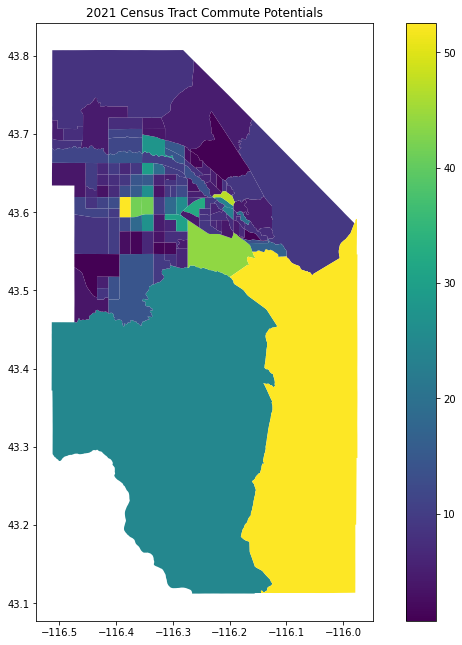

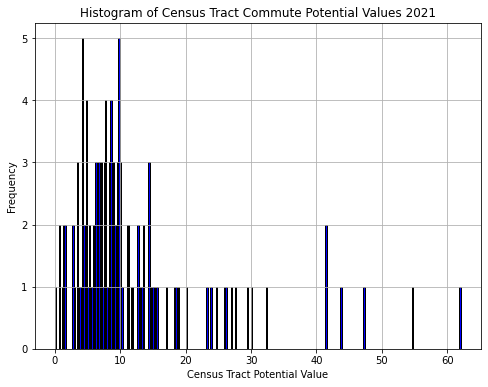

In [36]:
plot_urban_potential_3()

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3763837937.py:102: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1355347496.py:128: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1355347496.py:129: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


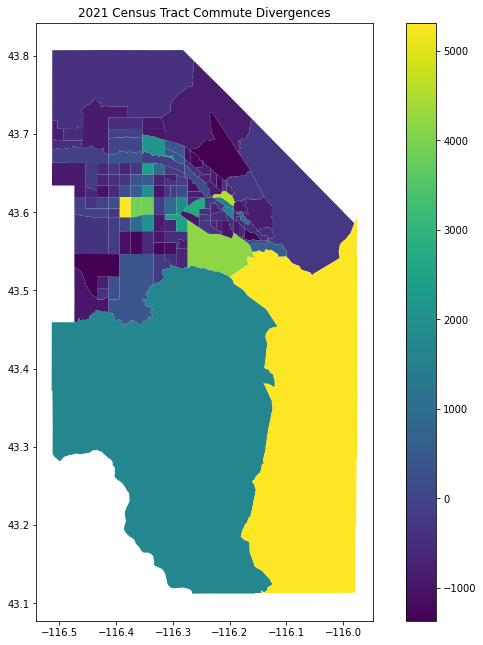

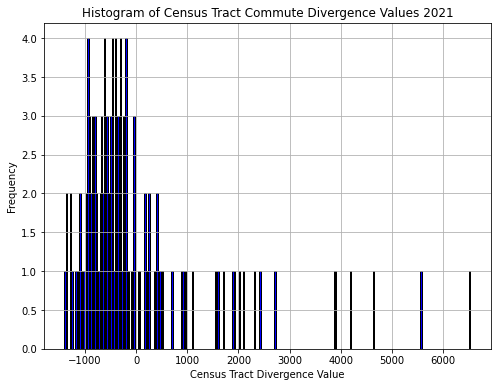

In [37]:
plot_urban_divergence_3()

In [9]:
plot_urban_potential_4()

C:\Users\DELL\AppData\Local\Temp\ipykernel_6096\3763837937.py:102: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3763837937.py:102: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1875099598.py:187: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1875099598.py:188: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


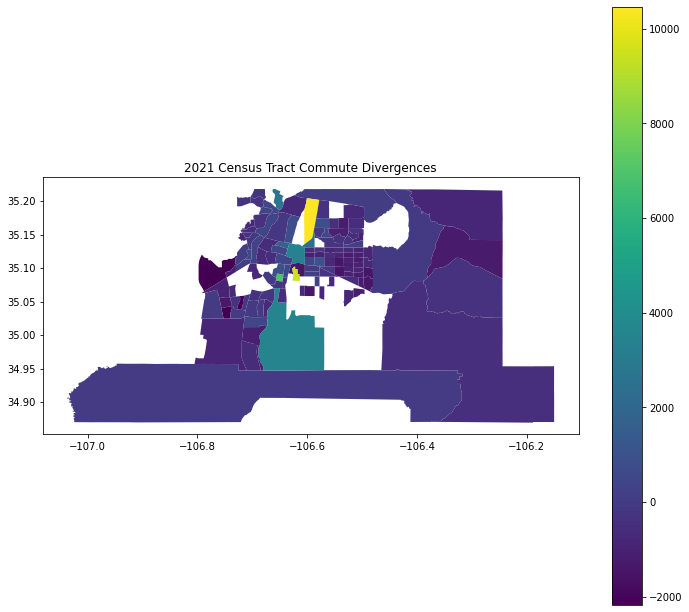

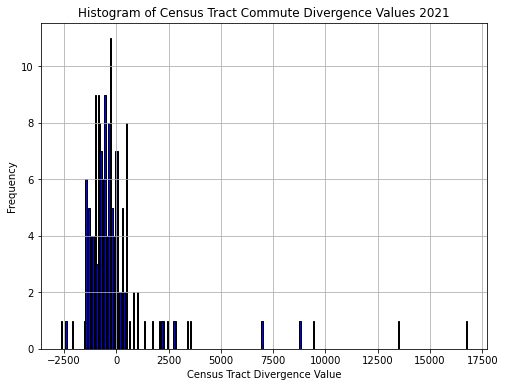

In [40]:
plot_urban_divergence_4()

In [42]:
plot_urban_potential_5()

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3763837937.py:102: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3763837937.py:102: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1932866681.py:155: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1932866681.py:156: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


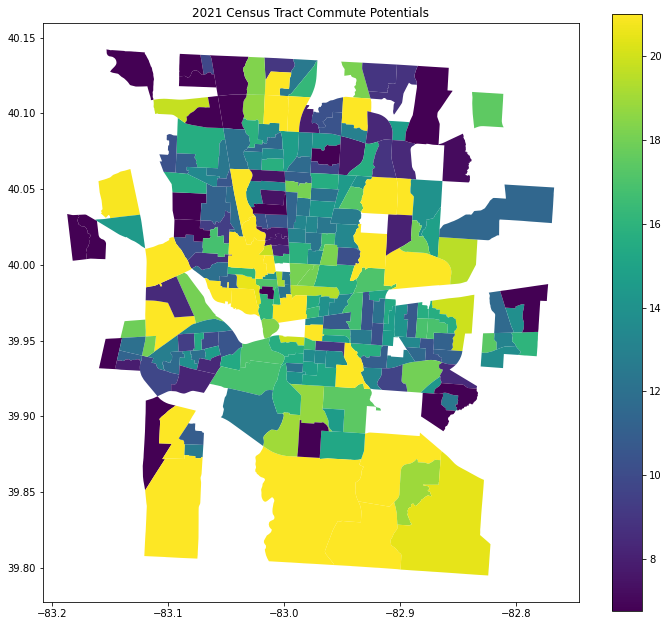

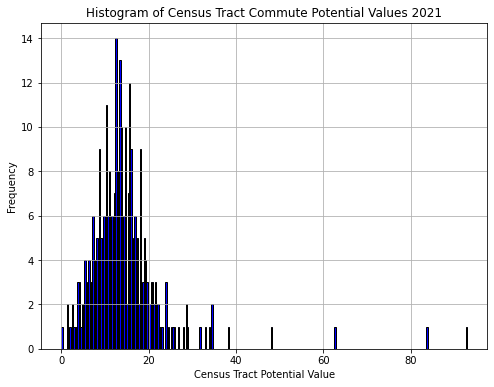

In [25]:
plot_urban_potential_6()

In [1]:
import pandas as pd

# df = pd.read_csv("wa_od_main_JT00_2021.csv")
# df = pd.read_csv("oh_od_main_JT00_2021.csv")
# df = pd.read_csv("id_od_main_JT00_2021.csv")
# df = pd.read_csv("nm_od_main_JT00_2021.csv")
df = pd.read_csv("wi_od_main_JT00_2021.csv")
# fips_dict = {"King":53033,"Snohomish":53061,"Pierce":53053,"Thurston":53067,
#             "Kitsap":53035,"Skagit":53057,"Island":53029,"Lewis":53041,"Mason":53045}
# fips_dict = {"King":53033}
# fips_dict = {"Franklin":39049}
# fips_dict = {"Ada":16001}
# fips_dict = {"Bernalillo":35001}
fips_dict = {"Wilwaukee":55079}
fips_list = list(str(i) for i in fips_dict.values())
df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
df = df[["w_geocode","h_geocode","S000"]]
df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
df

,w_geocode_first11_str,h_geocode_first11_str,S000
0,55079000101,55079000101,43
1,55079000101,55079000102,23
2,55079000101,55079000201,38
3,55079000101,55079000202,14
4,55079000101,55079000301,3
...,...,...,...
50060,55079980000,55079186900,2
50061,55079980000,55079187000,2
50062,55079980000,55079187300,2
50063,55079980000,55079187400,4


In [2]:
import pandas as pd

# df = pd.read_csv("wa_od_main_JT00_2021.csv")
# df = pd.read_csv("oh_od_main_JT00_2021.csv")
df = pd.read_csv("id_od_main_JT00_2021.csv")
# df = pd.read_csv("nm_od_main_JT00_2021.csv")
# df = pd.read_csv("wi_od_main_JT00_2021.csv")
# fips_dict = {"King":53033,"Snohomish":53061,"Pierce":53053,"Thurston":53067,
#             "Kitsap":53035,"Skagit":53057,"Island":53029,"Lewis":53041,"Mason":53045}
# fips_dict = {"King":53033}
# fips_dict = {"Franklin":39049}
fips_dict = {"Ada":16001}
# fips_dict = {"Bernalillo":35001}
# fips_dict = {"Wilwaukee":55079}
fips_list = list(str(i) for i in fips_dict.values())
df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
df = df[["w_geocode","h_geocode","S000"]]
df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
df

,w_geocode_first11_str,h_geocode_first11_str,S000
0,16001000101,16001000101,62
1,16001000101,16001000102,71
2,16001000101,16001000201,67
3,16001000101,16001000202,117
4,16001000101,16001000302,45
...,...,...,...
13688,16001010506,16001010411,15
13689,16001010506,16001010501,1
13690,16001010506,16001010503,9
13691,16001010506,16001010505,10


In [3]:
import pandas as pd

# df = pd.read_csv("wa_od_main_JT00_2021.csv")
# df = pd.read_csv("oh_od_main_JT00_2021.csv")
# df = pd.read_csv("id_od_main_JT00_2021.csv")
df = pd.read_csv("nm_od_main_JT00_2021.csv")
# df = pd.read_csv("wi_od_main_JT00_2021.csv")
# fips_dict = {"King":53033,"Snohomish":53061,"Pierce":53053,"Thurston":53067,
#             "Kitsap":53035,"Skagit":53057,"Island":53029,"Lewis":53041,"Mason":53045}
# fips_dict = {"King":53033}
# fips_dict = {"Franklin":39049}
# fips_dict = {"Ada":16001}
fips_dict = {"Bernalillo":35001}
# fips_dict = {"Wilwaukee":55079}
fips_list = list(str(i) for i in fips_dict.values())
df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
df = df[["w_geocode","h_geocode","S000"]]
df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
df

,w_geocode_first11_str,h_geocode_first11_str,S000
0,35001000107,35001000107,34
1,35001000107,35001000108,4
2,35001000107,35001000109,1
3,35001000107,35001000110,1
4,35001000107,35001000112,1
...,...,...,...
22230,35001980600,35001004742,2
22231,35001980600,35001004754,1
22232,35001980600,35001004755,1
22233,35001980600,35001004756,2


In [7]:
np.sum(df["S000"]>10)

17767

In [5]:
len(set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"])))

494

In [12]:
shapefile_path = 'Idaho census tract 2023/tl_2023_16_tract.shp'
gdf_10 = gpd.read_file(shapefile_path)
gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
gdf_10['YCOORD'] = gdf_10.geometry.centroid.y

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,16,051,960402,16051960402,1400000US16051960402,9604.02,Census Tract 9604.02,G5020,S,131247572,3310076,+43.6693599,-111.8002913,"POLYGON ((-111.92765 43.75706, -111.92763 43.7..."
1,16,051,960401,16051960401,1400000US16051960401,9604.01,Census Tract 9604.01,G5020,S,25617062,116023,+43.6582160,-111.8940292,"POLYGON ((-111.94220 43.62665, -111.94158 43.6..."
2,16,051,960301,16051960301,1400000US16051960301,9603.01,Census Tract 9603.01,G5020,S,34639731,160745,+43.6634228,-111.9570338,"POLYGON ((-111.98364 43.62657, -111.98358 43.6..."
3,16,051,960302,16051960302,1400000US16051960302,9603.02,Census Tract 9603.02,G5020,S,14360903,226035,+43.6824579,-111.9200089,"POLYGON ((-111.94372 43.67085, -111.94372 43.6..."
4,16,011,950102,16011950102,1400000US16011950102,9501.02,Census Tract 9501.02,G5020,S,46724833,2227195,+43.3894417,-112.1530206,"POLYGON ((-112.20526 43.34822, -112.20433 43.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,16,031,950200,16031950200,1400000US16031950200,9502,Census Tract 9502,G5020,S,163331897,5666958,+42.5409128,-113.6227583,"POLYGON ((-113.72492 42.43151, -113.72492 42.4..."
452,16,031,950100,16031950100,1400000US16031950100,9501,Census Tract 9501,G5020,S,4213342325,24740144,+42.2900770,-113.3791677,"POLYGON ((-113.84026 42.20990, -113.84003 42.2..."
453,16,007,950100,16007950100,1400000US16007950100,9501,Census Tract 9501,G5020,S,1221959660,88525914,+42.2556968,-111.2020074,"POLYGON ((-111.38066 42.43592, -111.38041 42.4..."
454,16,031,950400,16031950400,1400000US16031950400,9504,Census Tract 9504,G5020,S,6582704,1223209,+42.5419029,-113.7722816,"POLYGON ((-113.81374 42.53612, -113.81130 42.5..."
